<h1 style="text-align:center">Forest Cover Type Prediction</h1>

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. We are asked to predict an integer classification for the forest cover type. 

<h3 style="text-align:center">Load Libraries</h3>

In [1]:
import numpy as np
import pandas as pd

# Visualizations
import seaborn as sns 
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Ensemble algorithms
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


C:\Users\Melan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We add code to make the plot to be centered

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h3 style="text-align:center"> Load dataset</h3>

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

<h3 style="text-align:center">Analyze data</h3>

In [4]:
# shape
print("Train_df shape:", train_df.shape)
print("Test_df shape:", test_df.shape)

Train_df shape: (15120, 56)
Test_df shape: (565892, 55)


In [5]:
# Peek 
train_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


<u>Cover_Type</u> 

Let's look at the repartition of the Cover types which is the target feature 

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64


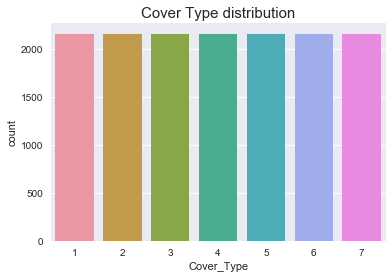

In [6]:
print( train_df.groupby("Cover_Type").size() )

sns.countplot(x="Cover_Type", data=train_df)
plt.title("Cover Type distribution", size=15)

We observe that the Types are equally distributed

<u>Missing values</u>

It's important to know how many missing values there are that will determine the amount of work when feature engineering

In [7]:
nans = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)[:5])
nans.columns = ['NaN Count in train_df']
nans.index.name = 'Feature'
nans

,NaN Count in train_df
Feature,
Cover_Type,0
Soil_Type40,0
Soil_Type11,0
Soil_Type10,0
Soil_Type9,0


In [8]:
nans = pd.DataFrame(test_df.isnull().sum().sort_values(ascending=False)[:5])
nans.columns = ['NaN Count in test_df']
nans.index.name = 'Feature'
nans

,NaN Count in test_df
Feature,
Soil_Type40,0
Wilderness_Area3,0
Soil_Type10,0
Soil_Type9,0
Soil_Type8,0


In [9]:
type(test_df.isnull().sum().sort_values(ascending=False))

pandas.core.series.Series

Interestingly enough, there's no missing values in both the train and test dataframes

<u>Types</u>

In [10]:
train_df.dtypes

Id                                    int64
Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                      

All the columns are integers, meaning that that they will require less transformation for the machine algorithms to handle to processing part.

<h3 style="text-align:center">Data exploration</h3>

<u>Correlation with Cover_Type</u>

In [11]:
corr = train_df.drop('Id', axis=1).corr()

print(corr['Cover_Type'].sort_values(ascending=False)[:10], "\n")
print(corr['Cover_Type'].sort_values(ascending=False)[-10:])

Cover_Type                        1.000000
Soil_Type38                       0.257810
Soil_Type39                       0.240384
Soil_Type40                       0.205851
Soil_Type10                       0.128972
Wilderness_Area3                  0.122146
Soil_Type35                       0.114327
Slope                             0.087722
Wilderness_Area4                  0.075774
Vertical_Distance_To_Hydrology    0.075647
Name: Cover_Type, dtype: float64 

Soil_Type24                       -0.100797
Horizontal_Distance_To_Roadways   -0.105662
Soil_Type12                       -0.129985
Soil_Type32                       -0.132312
Soil_Type23                       -0.158762
Soil_Type22                       -0.195993
Soil_Type29                       -0.218564
Wilderness_Area1                  -0.230117
Soil_Type7                              NaN
Soil_Type15                             NaN
Name: Cover_Type, dtype: float64


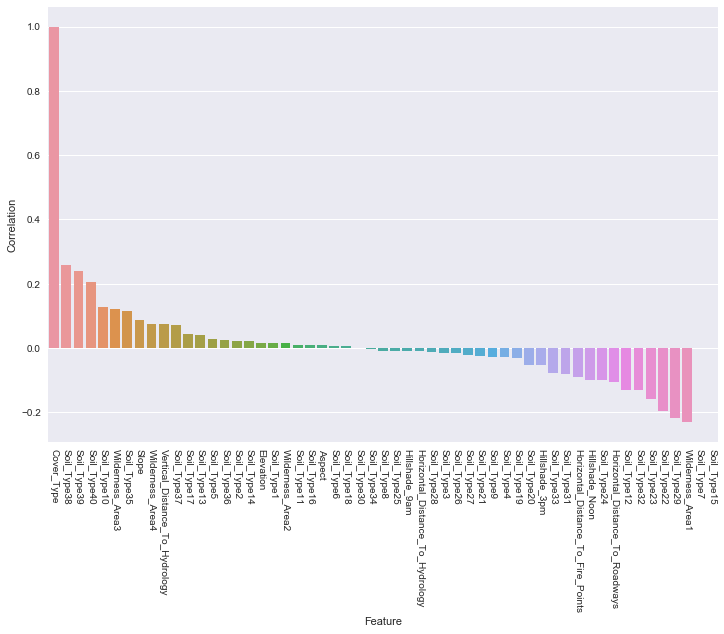

In [12]:
corr_df = pd.DataFrame(corr['Cover_Type'].sort_values(ascending=False))
corr_df.columns = ['Correlation']
corr_df.index.name = 'Feature'

plt.figure(figsize=(12,8))
# Seaborn's barplot returns an axis-object (not a figure). 
ax = sns.barplot(x=corr_df.index, y='Correlation', data=corr_df)
ax.set(ylabel='Correlation')
plt.xticks(rotation=-90)
plt.title('')

The correlation plot indicates that there is no particular strong features correlated with our target features of Cover_Type. <br>
Plus, One thing to notice is that Soil_Type7 and Soil_Type15 have all their attributes to be null since they aren't related to the target features.

<u>Removing outliers and irrelevant features relate to Soil Type</u>

In [13]:
def remove_SoilType_7_15(dataset):
    print("call to function")
    dataset.drop(['Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)
    
remove_SoilType_7_15(train_df)
remove_SoilType_7_15(test_df)

call to function
call to function


In [14]:
train_df.shape

(15120, 54)

<u>Outliers</u>

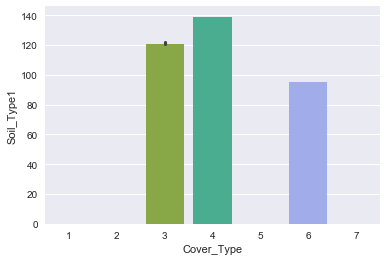

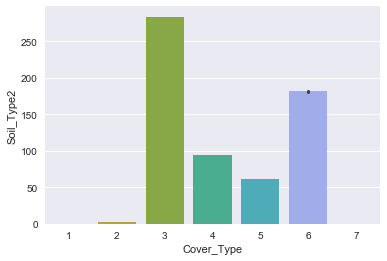

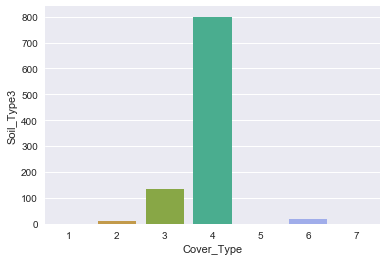

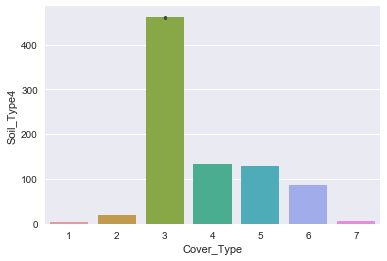

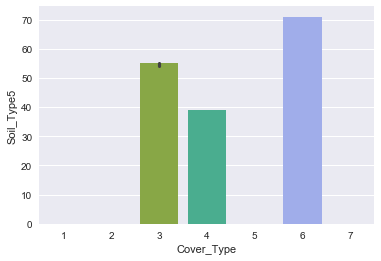

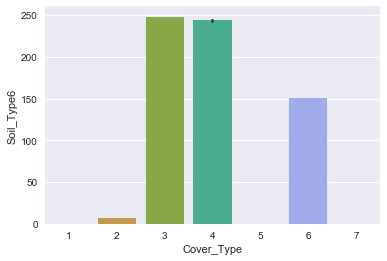

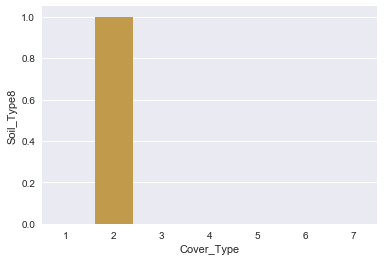

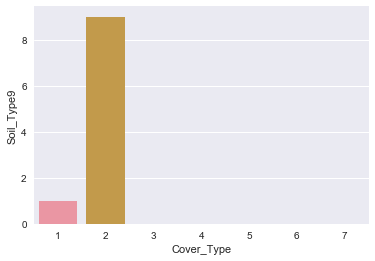

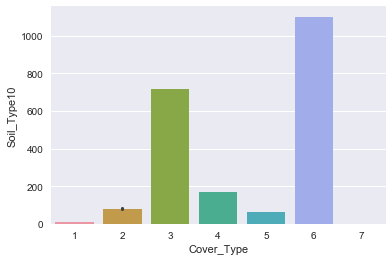

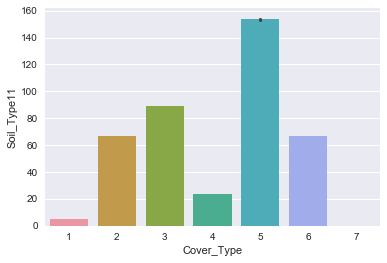

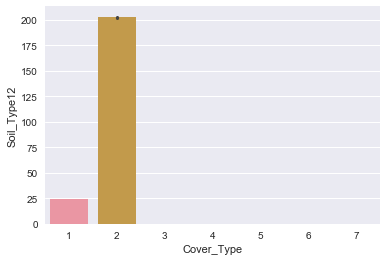

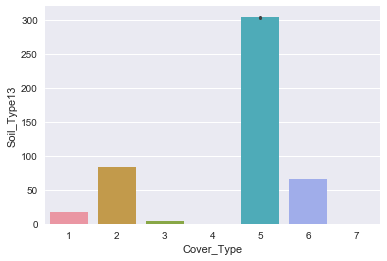

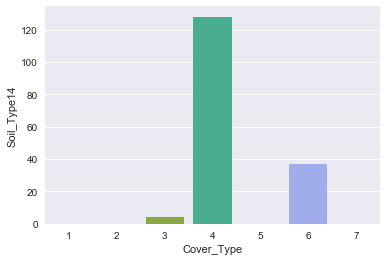

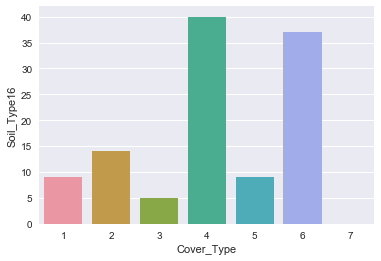

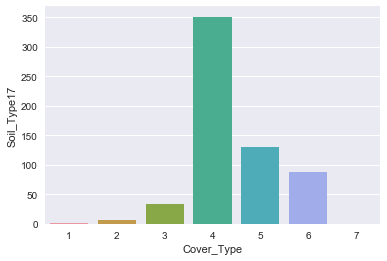

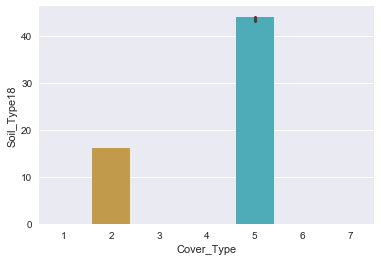

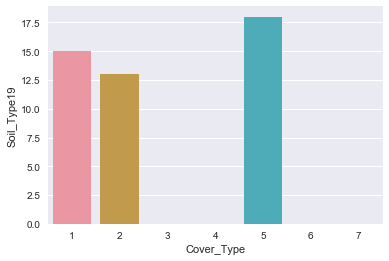

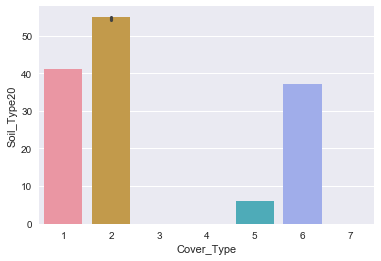

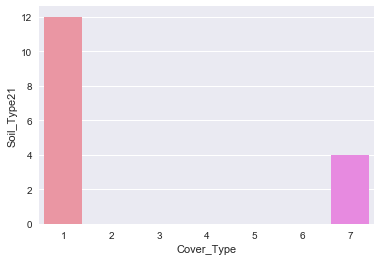

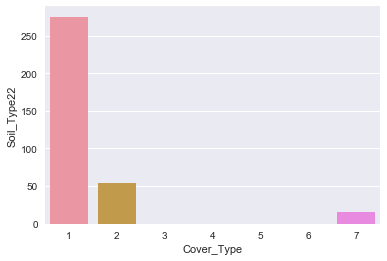

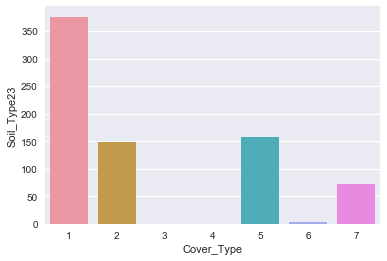

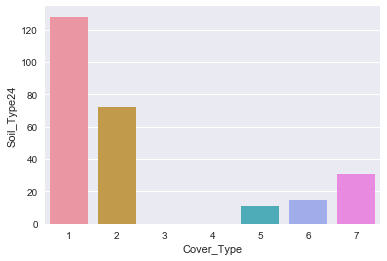

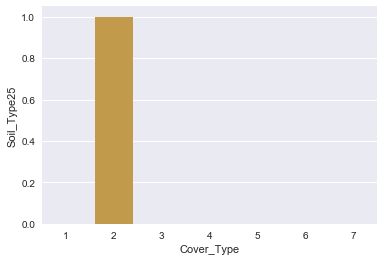

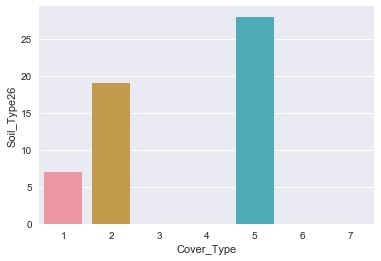

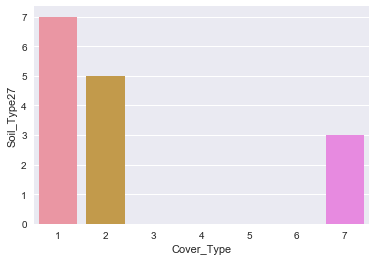

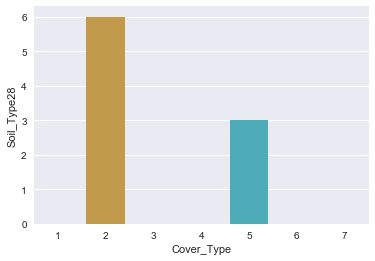

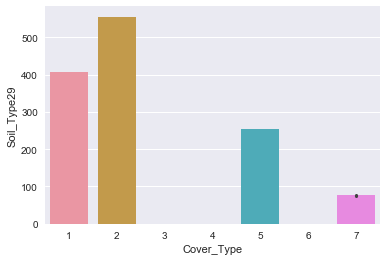

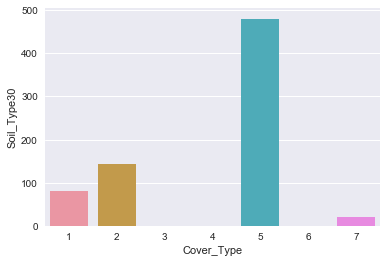

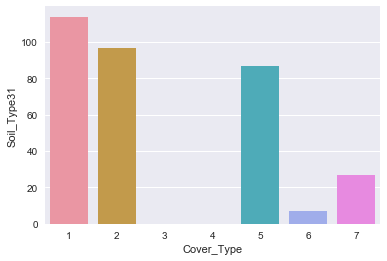

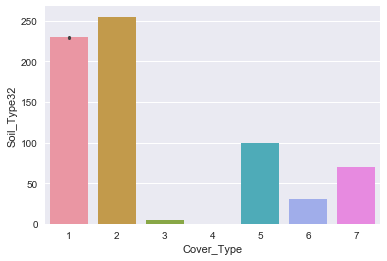

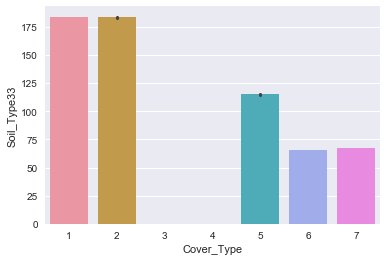

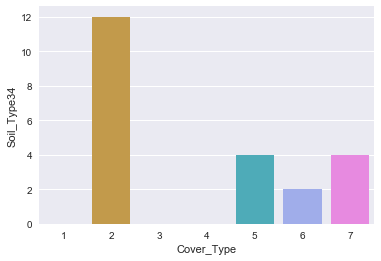

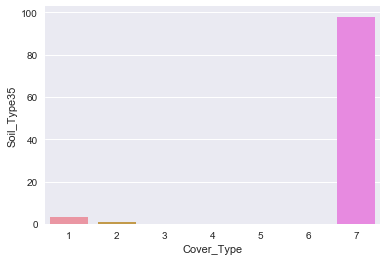

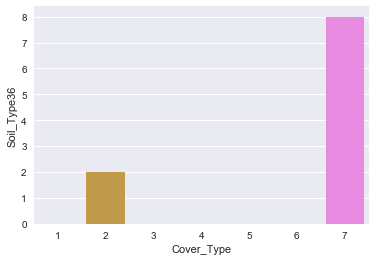

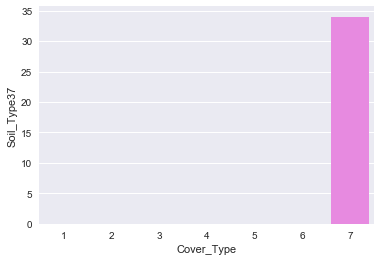

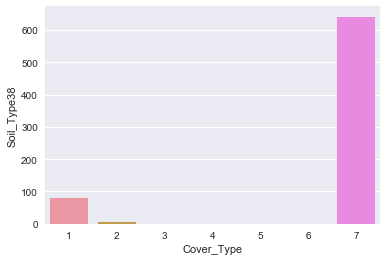

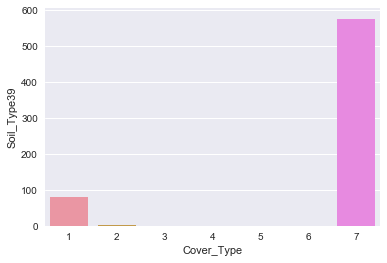

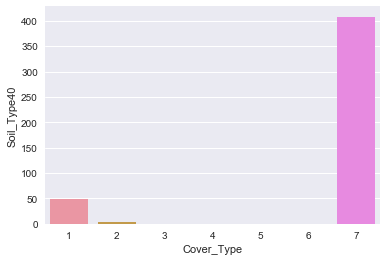

In [15]:
plt.subplot(111)
for i in range(1,41):
    if (i == 7 or i == 15):
        continue
    ax = sns.barplot(y='Soil_Type'+str(i),x='Cover_Type', data=train_df, ci=1, estimator=np.sum)
    ax.set(ylabel='Soil_Type'+str(i))
    plt.show()

From the different plots we observe some outliers we may want to exclude as they do not represent a generality.

In [16]:
# Soil_Type2
train_df.loc[(train_df['Cover_Type'] == 2) & (train_df['Soil_Type2'] == 1), 'Soil_Type2'] = 0

# Soil_Type3
train_df.loc[(train_df['Cover_Type'] == 2) & (train_df['Soil_Type3'] == 1), 'Soil_Type3'] = 0
train_df.loc[(train_df['Cover_Type'] == 6) & (train_df['Soil_Type3'] == 1), 'Soil_Type3'] = 0

# Soil_Type4
train_df.loc[ ( (train_df['Cover_Type'] == 1) 
             | (train_df['Cover_Type'] == 2)
             | (train_df['Cover_Type'] == 7) )
             & (train_df['Soil_Type4'] == 1), 'Soil_Type4'] = 0

# Soil_Type6
train_df.loc[(train_df['Cover_Type'] == 2) & (train_df['Soil_Type6'] == 1), 'Soil_Type6'] = 0

# Soil_Type10
train_df.loc[ ( (train_df['Cover_Type'] == 1)
             | (train_df['Cover_Type'] == 5) )
             & (train_df['Soil_Type10'] == 1), 'Soil_Type10'] = 0

# Soil_Type11
train_df.loc[(train_df['Cover_Type'] == 1) & (train_df['Soil_Type11'] == 1), 'Soil_Type11'] = 0

# Soil_Type13
train_df.loc[ ( (train_df['Cover_Type'] == 1)
             | (train_df['Cover_Type'] == 3) )
             & (train_df['Soil_Type13'] == 1), 'Soil_Type13'] = 0

# Soil_Type14
train_df.loc[(train_df['Cover_Type'] == 3) & (train_df['Soil_Type14'] == 1), 'Soil_Type14'] = 0

# Soil_Type17
train_df.loc[ ( (train_df['Cover_Type'] == 1)
             | (train_df['Cover_Type'] == 2) )
             & (train_df['Soil_Type17'] == 1), 'Soil_Type17'] = 0

# Soil_Type23
train_df.loc[(train_df['Cover_Type'] == 6) & (train_df['Soil_Type23'] == 1), 'Soil_Type23'] = 0

# Soil_Type30
train_df.loc[(train_df['Cover_Type'] == 7) & (train_df['Soil_Type30'] == 1), 'Soil_Type30'] = 0

# Soil_Type31
train_df.loc[(train_df['Cover_Type'] == 6) & (train_df['Soil_Type31'] == 1), 'Soil_Type31'] = 0

# Soil_Type32
train_df.loc[(train_df['Cover_Type'] == 3) & (train_df['Soil_Type32'] == 1), 'Soil_Type32'] = 0

# Soil_Type35
train_df.loc[ ( (train_df['Cover_Type'] == 1)
             | (train_df['Cover_Type'] == 2) )
             & (train_df['Soil_Type35'] == 1), 'Soil_Type35'] = 0

# Soil_Type38
train_df.loc[(train_df['Cover_Type'] == 2) & (train_df['Soil_Type38'] == 1), 'Soil_Type38'] = 0

# Soil_Type39
train_df.loc[(train_df['Cover_Type'] == 2) & (train_df['Soil_Type39'] == 1), 'Soil_Type39'] = 0

# Soil_Type40
train_df.loc[(train_df['Cover_Type'] == 2) & (train_df['Soil_Type40'] == 1), 'Soil_Type40'] = 0


<u> Wilderness Area</u>

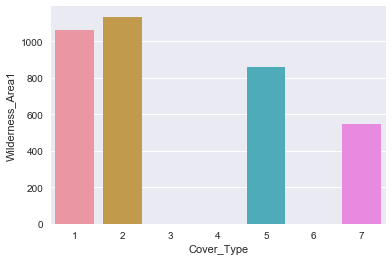

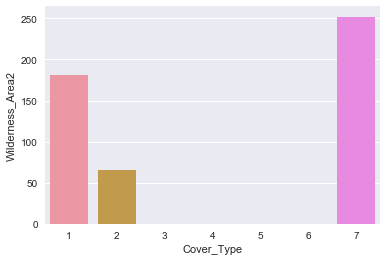

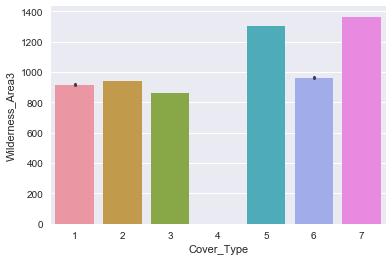

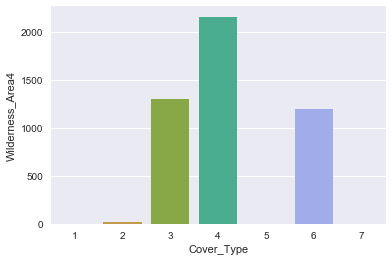

In [17]:
plt.subplot(111)
for i in range(1,5):
    ax = sns.barplot(y='Wilderness_Area'+str(i),x='Cover_Type', data=train_df, ci=1, estimator=np.sum)
    ax.set(ylabel='Wilderness_Area'+str(i))
    plt.show()

We remove the outlier in Wilderness_Area4

In [18]:
train_df.loc[(train_df['Cover_Type'] == 2) & (train_df['Wilderness_Area4'] == 1), 'Wilderness_Area4'] = 0

<u>Slope</u>

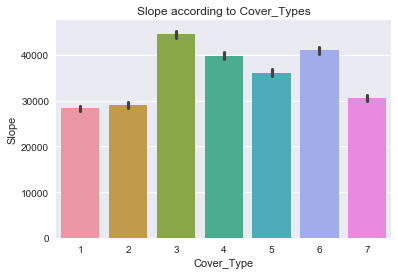

In [19]:
ax = sns.barplot(y='Slope', x='Cover_Type', data=train_df, estimator=np.sum)
ax.set(ylabel='Slope')
plt.title('Slope according to Cover_Types')

There is nothing alarming looking at the preceding plot

<u>Vertical_Distance_To_Hydrology</u>

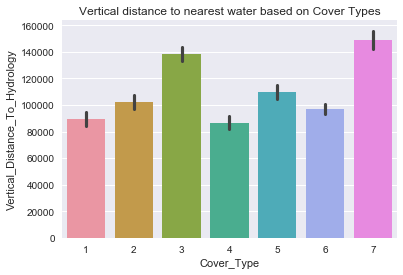

In [20]:
ax = sns.barplot(y='Vertical_Distance_To_Hydrology', x='Cover_Type', data=train_df, estimator=np.sum)
ax.set(ylabel='Vertical_Distance_To_Hydrology')
plt.title('Vertical distance to nearest water based on Cover Types')

<u>Horizontal_Distance_To_Roadways </u>

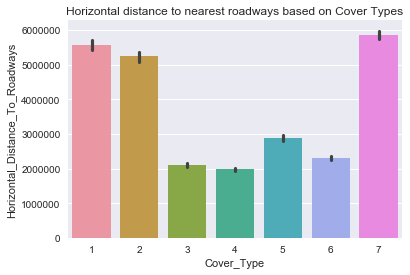

In [21]:
ax = sns.barplot(y='Horizontal_Distance_To_Roadways', x='Cover_Type', data=train_df, estimator=np.sum)
ax.set(ylabel='Horizontal_Distance_To_Roadways')
plt.title('Horizontal distance to nearest roadways based on Cover Types')

From the 3 previous plots, we observe that that the order of magnitude is changing. <br>
We may need to standardize those numerical features in order to benefit from the machine learning algorithms

In [22]:
end = train_df.columns.get_loc('Wilderness_Area1')
num_features_train_df = train_df.iloc[:, 1:end]
train_df.iloc[:, 1:end].head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,2596,51,3,258,0,510,221,232,148,6279
1,2590,56,2,212,-6,390,220,235,151,6225
2,2804,139,9,268,65,3180,234,238,135,6121
3,2785,155,18,242,118,3090,238,238,122,6211
4,2595,45,2,153,-1,391,220,234,150,6172


In [24]:
end = train_df.columns.get_loc('Wilderness_Area1')
num_features_train_df = train_df.iloc[:, 1:end]

scaler = StandardScaler().fit(num_features_train_df)
train_df.iloc[:, 1:end] = scaler.transform(num_features_train_df)

test_df.iloc[:, 1:end] = scaler.transform(test_df.iloc[:, 1:end])

We fit the <i>StandardScaler</i> only once on the training data and use those parameters to transform the test set or any new data point

<h3 style="text-align:center">Split-out dataset</h3>

The training set will be split into a train and evaluation set. <br>
This aims to observe how well the algorithms will perform on unseen data so that we will able to see if there is any overfitting (or underfitting) issues.

In [35]:
# Test options and evaluation metric 
num_folds = 10
seed = 46
test_size = 0.20
scoring = 'accuracy'

In [39]:
X_train = train_df.drop(['Id', 'Cover_Type'], axis=1)
y_train = train_df['Cover_Type']

print("X_train.shape:", X_train.shape, ", y_train.shape:", Y_train.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, \
                                                 random_state=seed)

print()
print("X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
print("X_val.shape:",X_val.shape, "y_val.shape:", y_val.shape)

X_train.shape: (15120, 52) , y_train.shape: (15120,)

X_train.shape: (12096, 52) y_train.shape: (12096,)
X_val.shape: (3024, 52) y_val.shape: (3024,)
